# Test model on test data

In [1]:
import numpy as np
import pandas as pd
import math
import csv

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from inspect import getsourcefile
import glob
import os
import os.path as osp

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

from joblib import dump, load

In [2]:
DIR = '/'.join(osp.realpath(getsourcefile(lambda: 0)).split('/')[:-2])
DIR_DATA = DIR + '/data/her2st'
DIR_RES = DIR + '/results'
print('', DIR, '\n', DIR_DATA)

 /Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project 
 /Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st


## Read data and model

### X

In [3]:
test_df = pd.read_csv(os.path.join(DIR_DATA, 'test_df.tsv'), sep='\t')
test_df.shape

(944, 12696)

In [4]:
test_samples = test_df['sample_id'].unique().tolist()
test_samples

['A1', 'B1', 'D1']

In [5]:
fname = DIR_RES + '/train_features.csv'
feats = pd.read_csv(fname, sep=',', header=None)
features_use = feats.iloc[:,0].tolist()
len(features_use)

1517

In [6]:
test_df_reduced = test_df.copy()
test_df_reduced = test_df_reduced.loc[:, features_use]
test_df_reduced.shape

(944, 1517)

In [7]:
X = np.array(test_df_reduced)

### y

In [8]:
le = preprocessing.LabelEncoder()
le.fit(test_df['label_cancer'])
list(le.classes_)

['cancer', 'healthy']

In [9]:
test_df['label_bin'] = le.transform(test_df['label_cancer'])

In [10]:
test_df['label'] = np.abs(test_df['label_bin']-1)

In [11]:
y = np.array(test_df['label'].tolist())

### Model

In [12]:
model_fname = DIR_RES+'/model_rf.joblib'
clf = load(model_fname)
clf

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=100,
                       n_jobs=-1, random_state=1337)

## Use model on test data

Use the final model to predict cancer labels on the test data

In [14]:
test_samples = test_df['sample_id'].unique().tolist()

res_test = dict()
y_preds = dict()
for sample_id in test_samples:
    
    print(sample_id)
    sample_idx = test_df.loc[test_df['sample_id']==sample_id,:].index.tolist()
    #print(len(sample_idx))
    X_sample = X[sample_idx,:]
    y_sample = y[sample_idx]
    #print(X_sample.shape)
    #print(len(y_sample))
    
    y_sample_pred = clf.predict(X_sample) 
    y_preds.update({sample_id:y_sample_pred})
    
    acc = accuracy_score(y_sample, y_sample_pred)
    f1 = f1_score(y_sample, y_sample_pred)
    mcc = matthews_corrcoef(y_sample, y_sample_pred)
    
    print("Accuracy score: %s" % acc)
    print("F1 score: %s" % f1)
    print("MCC score: %s" % mcc)
    
    res_metrics = {'Accuracy':acc, 'F1':f1, 'MCC':mcc}
    res_test.update({sample_id:res_metrics})

A1
Accuracy score: 0.8869565217391304
F1 score: 0.9389671361502347
MCC score: 0.29170451298439387
B1
Accuracy score: 0.931740614334471
F1 score: 0.8507462686567164
MCC score: 0.8091249174797942
D1
Accuracy score: 0.5130718954248366
F1 score: 0.6494117647058824
MCC score: 0.21470197784465905


In [15]:
res_test

{'A1': {'Accuracy': 0.8869565217391304,
  'F1': 0.9389671361502347,
  'MCC': 0.29170451298439387},
 'B1': {'Accuracy': 0.931740614334471,
  'F1': 0.8507462686567164,
  'MCC': 0.8091249174797942},
 'D1': {'Accuracy': 0.5130718954248366,
  'F1': 0.6494117647058824,
  'MCC': 0.21470197784465905}}

A1
B1
D1


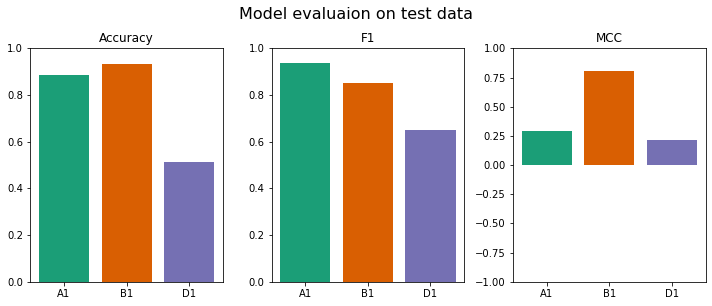

In [16]:
sns.set_palette("Dark2")
legend_text=[]

n_cols=3
n_rows=1
fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (10, 4))
fig.suptitle("Model evaluaion on test data", y=1.05, size = 16)

for x, sample_id in enumerate(res_test):
    print(sample_id)
    res_metrics = res_test[sample_id]
    legend_text.append(sample_id)
    for k, metric in enumerate(res_metrics):
        #print(res_metrics[metric])
        ax[k].bar(x, res_metrics[metric])
        ax[k].set_xticks(range(0, len(legend_text)))
        ax[k].set_xticklabels(legend_text, rotation=0)
        ax[k].set_title(metric)
        if metric == "MCC":
            ax[k].set_ylim(-1, 1)
        else:
            ax[k].set_ylim(0, 1)
plt.tight_layout()

**Plot predictions spatially**

In [17]:
test_df_pred = test_df.copy()
test_df_pred['label_preds'] = 0
test_df_pred['y_inv'] = test_df_pred['y']*-1

In [18]:
for sample_id in test_samples:
    test_df_pred.loc[test_df_pred['sample_id']==sample_id, 'label_preds'] = y_preds[sample_id].tolist()

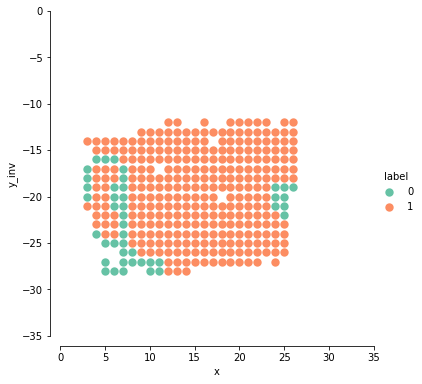

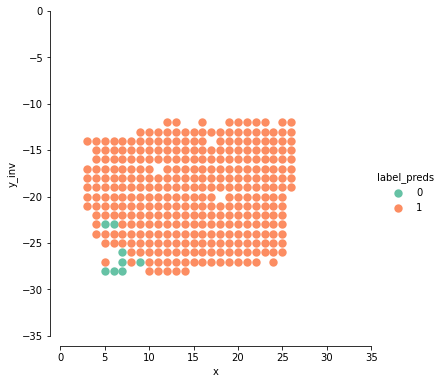

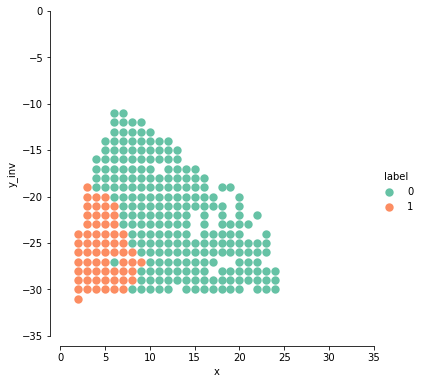

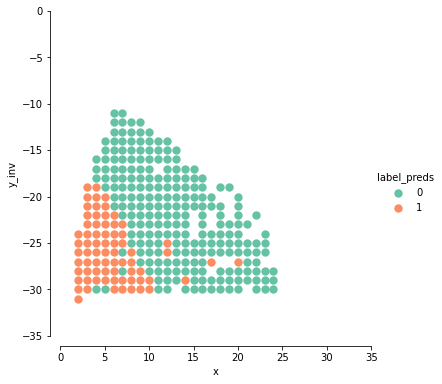

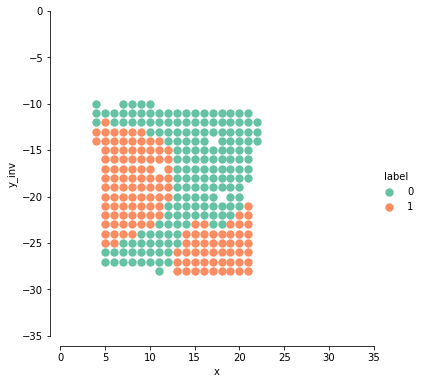

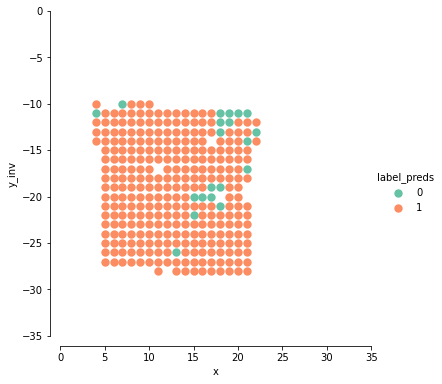

In [19]:
for sample_id in test_samples:
    d_plot = test_df_pred.loc[test_df_pred['sample_id']==sample_id, :].copy()
    sns.set_palette("Set2")

    sns.pairplot(x_vars=["x"], y_vars=["y_inv"], data=d_plot, 
                 hue="label", 
                 height=5,
                 plot_kws=dict(s=70, edgecolor="grey", linewidth=0, alpha=1)
                )
    plt.xlim(0, 35)
    plt.ylim(-35, 0)
    sns.despine(offset=10, trim=True);

    sns.pairplot(x_vars=["x"], y_vars=["y_inv"], data=d_plot, 
                 hue="label_preds", 
                 height=5,
                 plot_kws=dict(s=70, edgecolor="grey", linewidth=0, alpha=1)
                )
    plt.xlim(0, 35)
    plt.ylim(-35, 0)
    sns.despine(offset=10, trim=True);

***

In [20]:
import datetime
print('Last update done: ', datetime.datetime.now(), '\n',
     "Lovisa Franzén", sep='')

Last update done: 2020-08-30 21:35:08.422635
Lovisa Franzén


***